# Load Data

In [1]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime
import os
import matplotlib.pyplot as plt
import math
import numpy as np
sd = datetime(1980,1,1)
ed = datetime.today()
df= pd.DataFrame(index=pd.date_range(start=sd,end=ed, freq='D'))
#df = pd.DataFrame()
investments ={
    "Bitcoin":"BTC-USD",    
    "Tesla":"TSLA",    
    "S&P500":"VFINX",
    "Bond":"VBMFX",
    "Gold": "GC=F",
}

investments_data = "investments_data.csv"
s=[]
if (os.path.exists(investments_data)):
    print("Load existing data")
    df = pd.read_csv(investments_data, parse_dates=True,index_col='Date')
else:
    for name in investments.keys():
        s = (pdr.get_data_yahoo(symbols=investments[name], start=sd, end=ed)["Adj Close"])
        #drop duplicated index
        s = s.groupby(level=0).last()
        df[name]=s
    df.to_csv(path_or_buf=investments_data,index_label='Date')
print(df.head(10),)
print(df.tail(10),)
#df.columns

Load existing data
            Bitcoin  Tesla    S&P500  Bond  Gold
Date                                            
1980-01-01      NaN    NaN       NaN   NaN   NaN
1980-01-02      NaN    NaN  4.752916   NaN   NaN
1980-01-03      NaN    NaN  4.729715   NaN   NaN
1980-01-04      NaN    NaN  4.789373   NaN   NaN
1980-01-05      NaN    NaN       NaN   NaN   NaN
1980-01-06      NaN    NaN       NaN   NaN   NaN
1980-01-07      NaN    NaN  4.802632   NaN   NaN
1980-01-08      NaN    NaN  4.898751   NaN   NaN
1980-01-09      NaN    NaN  4.905380   NaN   NaN
1980-01-10      NaN    NaN  4.941841   NaN   NaN
                 Bitcoin       Tesla      S&P500   Bond         Gold
Date                                                                
2020-12-04  18699.765625  599.039978  342.359985  11.58  1835.900024
2020-12-05  19154.230469         NaN         NaN    NaN          NaN
2020-12-06  19345.121094         NaN         NaN    NaN          NaN
2020-12-07  19191.630859  641.760010  341.690002

In [2]:
sd = datetime(2015,1,1)
ed = datetime(2019,12,31)
truncated_df = df.fillna(method='ffill').truncate(before=sd,after=ed)

print(truncated_df.head(10))
print(truncated_df.tail(10))

               Bitcoin      Tesla      S&P500      Bond         Gold
Date                                                                
2015-01-01  314.248993  44.481998  170.486542  9.384991  1183.900024
2015-01-02  315.032013  43.862000  170.450638  9.410891  1186.000000
2015-01-03  281.082001  43.862000  170.450638  9.410891  1186.000000
2015-01-04  264.195007  43.862000  170.450638  9.410891  1186.000000
2015-01-05  274.473999  42.018002  167.344223  9.436790  1203.900024
2015-01-06  286.188995  42.256001  165.853836  9.471324  1219.300049
2015-01-07  294.337006  42.189999  167.837997  9.471324  1210.599976
2015-01-08  283.348999  42.124001  170.836731  9.445423  1208.400024
2015-01-09  290.407990  41.332001  169.400208  9.471324  1216.000000
2015-01-10  274.795990  41.332001  169.400208  9.471324  1216.000000
                Bitcoin      Tesla      S&P500       Bond         Gold
Date                                                                  
2019-12-22  7511.588867  81.11

In [3]:
from lib import drawdown,plot_drawdown,cagr
print(type(truncated_df['Tesla']))
print(truncated_df['Tesla'].idxmax())
drawdown(truncated_df['Tesla'])

<class 'pandas.core.series.Series'>
2019-12-26 00:00:00


-0.5282820677145933

In [4]:
from lib import drawdown,plot_drawdown,cagr

# Get MDD
print("MDD")
for name in investments.keys():
    print(drawdown(truncated_df[name]).min())
    plot_drawdown(truncated_df[name])
print("CAGR")
# Get CAGR
period=720
for name in investments.keys():
    start =(truncated_df[name].iloc[0])
    end = (truncated_df[name].iloc[-1])
    #print (df[name].head(10))
    #print (df[name].tail(10))    
    #print(end/start)
    cagrs = truncated_df[name].rolling(period).apply(func=lambda v:cagr(v.iloc[0],v.iloc[-1],period),raw=False)
    total_cagr = cagr(start,end, 365*4)
    #print(name)
    print(cagrs.std())
    #print(total_cagr)

MDD
-0.8339473159907649
-0.5282820677145933
-0.19329476497098097
-0.0430687052394578
-0.19197965100849382
CAGR
1.3576235406517978
0.164502615416267
0.04042168781989597
0.015289356261021604
0.04086387200374189


-0.5366820627320001
-0.2960034281335639
-0.15592237043056084
-0.027306126936037137
-0.10457718263264185


Text(0, 0.5, 'log(P(x))')

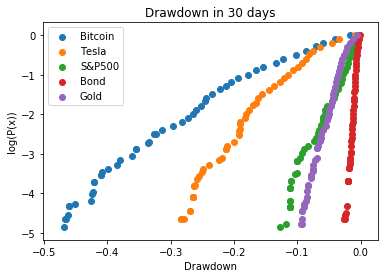

In [5]:
period=30
for name in investments.keys():
    s=truncated_df[name]
    drawdowns = s.rolling(period).apply(func=drawdown,raw=False)
    mdd = drawdowns.min()
    x=list(map(lambda v:drawdowns.quantile(math.exp(-v*0.1)),np.arange(0,50)))
    print(drawdowns.quantile(0.001))
    y = list(map(lambda v:math.log((drawdowns<=v).sum()/drawdowns.count()),x))
    plt.scatter (x,y,label=name)
    plt.legend()
plt.title(f'Drawdown in {period} days')
plt.xlabel('Drawdown')
plt.ylabel('log(P(x))')
